<a href="https://colab.research.google.com/github/RoshiniAish1999/Few-Shot-Learning/blob/main/Thesis_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Google Drive and install required packages
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision Pillow scikit-learn matplotlib numpy

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-

In [ ]:
# Cell 2: Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Dataset structure:

brain_tumor/
├── Training/
│   ├── glioma/ [images]
│   ├── meningioma/ [images]
│   ├── notumor/ [images]
│   └── pituitary/ [images]
└── Testing/
    ├── glioma/ [images]
    ├── meningioma/ [images]
    ├── notumor/ [images]
    └── pituitary/ [images]


Using device: cpu

Verifying training data...


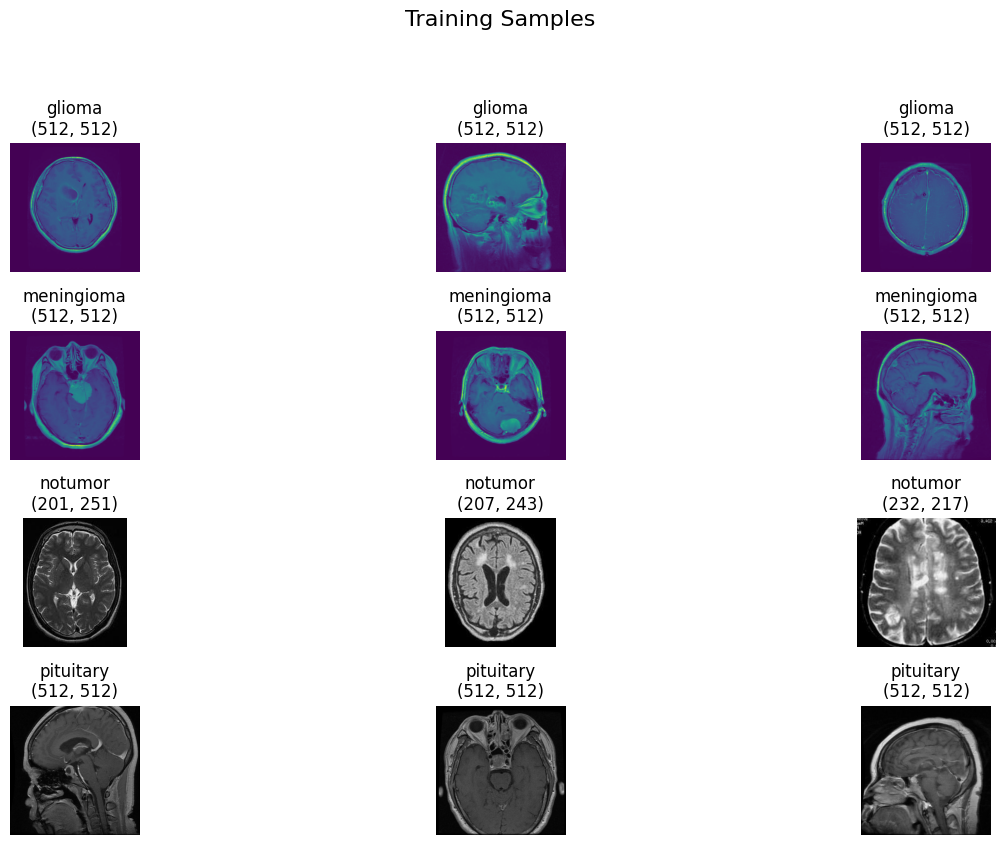

Verifying test data...


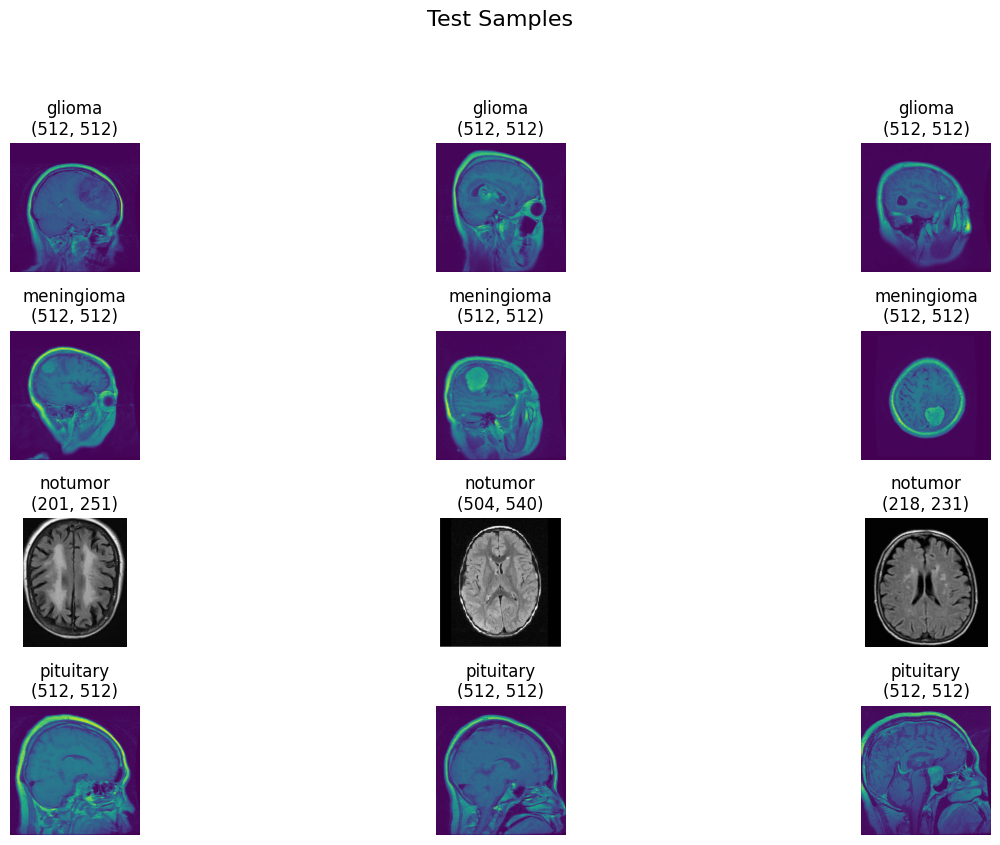

In [ ]:
# Cell 3: Dataset Setup + Verification
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

# --- Dataset Structure Note ---
print("Dataset structure:")
print("""
brain_tumor/
├── Training/
│   ├── glioma/ [images]
│   ├── meningioma/ [images]
│   ├── notumor/ [images]
│   └── pituitary/ [images]
└── Testing/
    ├── glioma/ [images]
    ├── meningioma/ [images]
    ├── notumor/ [images]
    └── pituitary/ [images]
""")

# --- Path Configuration ---
data_path = "/content/drive/MyDrive/brain_tumor"
train_path = os.path.join(data_path, "Training")
test_path = os.path.join(data_path, "Testing")

# Parameters
image_size = (128, 128)
batch_size = 16
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# --- Dataset Verification ---
def show_sample_images(folder_path, title="Sample Images", n_samples=3):
    classes = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=16, y=1.05)

    for i, class_name in enumerate(classes):
        class_path = os.path.join(folder_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')][:n_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(len(classes), n_samples, i*n_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.size}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display samples (if paths exist)
if os.path.exists(train_path):
    print("\nVerifying training data...")
    show_sample_images(train_path, "Training Samples")
else:
    print(f"\n⚠️ Training path not found: {train_path}")

if os.path.exists(test_path):
    print("Verifying test data...")
    show_sample_images(test_path, "Test Samples")
else:
    print(f"⚠️ Test path not found: {test_path}")

In [ ]:
# Cell 4: Create custom dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train', n_shot=5):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        self.n_shot = n_shot

        # Create few-shot samples (n_shot per class)
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_path):
                images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.endswith('.jpg')]
                # Use only n_shot images per class for training
                if mode == 'train':
                    images = images[:self.n_shot]
                for img_path in images:
                    self.samples.append((img_path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Cell 5: Create few-shot datasets and dataloaders
n_shot = 5  # Number of samples per class for few-shot learning

train_dataset = BrainTumorDataset(train_path, transform=transform, mode='train', n_shot=n_shot)
test_dataset = BrainTumorDataset(test_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Training samples: {len(train_dataset)} (Few-shot with {n_shot} samples per class)")
print(f"Testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 20 (Few-shot with 5 samples per class)
Testing samples: 16
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Cell 6: Define the Prototypical Network architecture with attention
class PrototypicalNetwork(nn.Module):
    def __init__(self, num_classes):
        super(PrototypicalNetwork, self).__init__()
        self.num_classes = num_classes

        # Feature extractor (simple CNN)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Classifier (not used in prototype computation)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x, compute_prototypes=False):
        features = self.features(x)

        # Apply attention
        attention_weights = self.attention(features)
        attended_features = features * attention_weights

        # Global average pooling
        pooled = F.adaptive_avg_pool2d(attended_features, (1, 1)).view(x.size(0), -1)

        if compute_prototypes:
            return pooled
        else:
            return self.classifier(pooled), attention_weights

    # In your PrototypicalNetwork class (Cell 6), add:
def __init__(self, num_classes, use_attention=True):
    self.use_attention = use_attention
    if use_attention:
        self.attention = nn.Sequential(...)  # Your existing attention
    else:
        self.attention = nn.Identity()  # Ablation study control

In [ ]:
# Cell 7: Define training and evaluation functions
def compute_prototypes(model, data_loader):
    model.eval()
    prototypes = torch.zeros(model.num_classes, 512).to(device)
    class_counts = torch.zeros(model.num_classes).to(device)

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            features = model(images, compute_prototypes=True)

            for i in range(model.num_classes):
                mask = (labels == i)
                if mask.any():
                    prototypes[i] += features[mask].sum(0)
                    class_counts[i] += mask.sum()

    prototypes = prototypes / class_counts.unsqueeze(1)
    return prototypes

def evaluate_prototypes(model, prototypes, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            features = model(images, compute_prototypes=True)

            # Compute distances to prototypes
            distances = torch.cdist(features.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
            preds = torch.argmin(distances, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

def train_model(model, train_loader, test_loader, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute prototypes and evaluate
        prototypes = compute_prototypes(model, train_loader)
        train_proto_acc = evaluate_prototypes(model, prototypes, train_loader)
        test_proto_acc = evaluate_prototypes(model, prototypes, test_loader)

        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)
        test_accuracies.append(test_proto_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}")
        print(f"Train Acc: {train_acc:.2f}% | Train Proto Acc: {train_proto_acc:.2f}%")
        print(f"Test Proto Acc: {test_proto_acc:.2f}%")
        print("-" * 50)

    return train_accuracies, test_accuracies

In [ ]:
# Cell 8: Initialize model and start training
num_classes = len(train_dataset.classes)
model = PrototypicalNetwork(num_classes).to(device)

epochs = 20
train_acc, test_acc = train_model(model, train_loader, test_loader, epochs=epochs)

Epoch 1/20
Train Loss: 1.1481
Train Acc: 50.00% | Train Proto Acc: 55.00%
Test Proto Acc: 62.50%
--------------------------------------------------
Epoch 2/20
Train Loss: 1.0328
Train Acc: 55.00% | Train Proto Acc: 65.00%
Test Proto Acc: 62.50%
--------------------------------------------------
Epoch 3/20
Train Loss: 0.8806
Train Acc: 75.00% | Train Proto Acc: 65.00%
Test Proto Acc: 56.25%
--------------------------------------------------
Epoch 4/20
Train Loss: 0.7600
Train Acc: 90.00% | Train Proto Acc: 80.00%
Test Proto Acc: 75.00%
--------------------------------------------------
Epoch 5/20
Train Loss: 1.5222
Train Acc: 75.00% | Train Proto Acc: 85.00%
Test Proto Acc: 56.25%
--------------------------------------------------
Epoch 6/20
Train Loss: 0.6331
Train Acc: 90.00% | Train Proto Acc: 80.00%
Test Proto Acc: 43.75%
--------------------------------------------------
Epoch 7/20
Train Loss: 0.6826
Train Acc: 85.00% | Train Proto Acc: 80.00%
Test Proto Acc: 50.00%
---------------

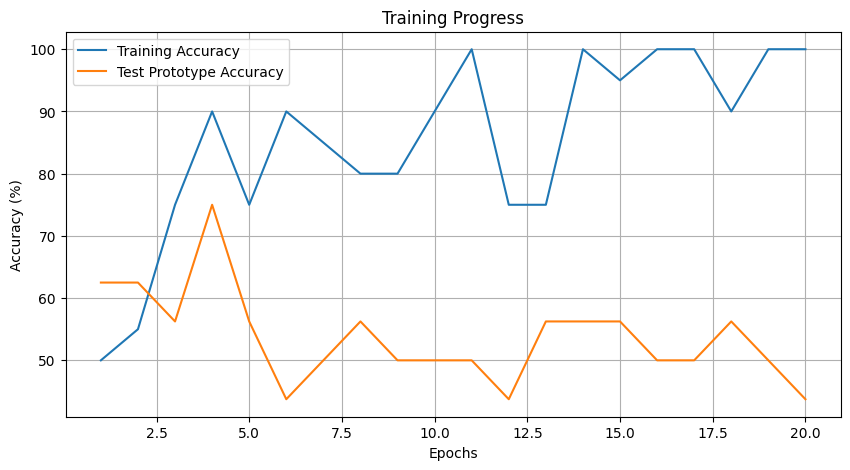

In [ ]:
# Cell 9: Plot training results
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_acc, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_acc, label='Test Prototype Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid()
plt.show()

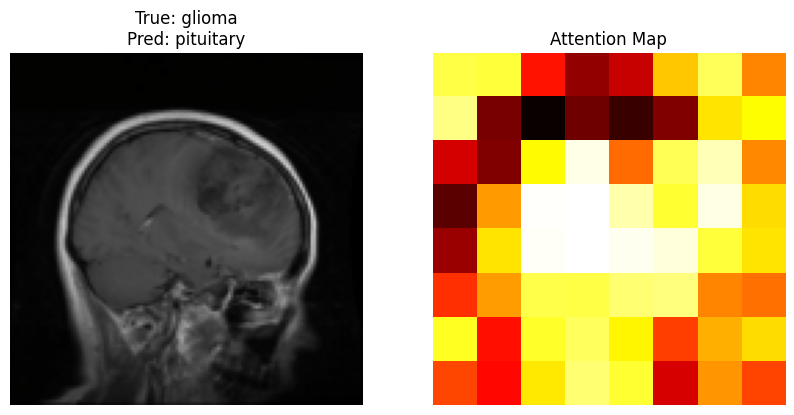

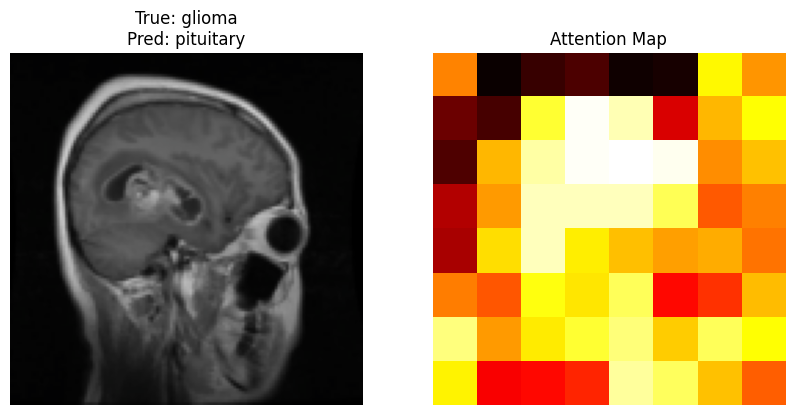

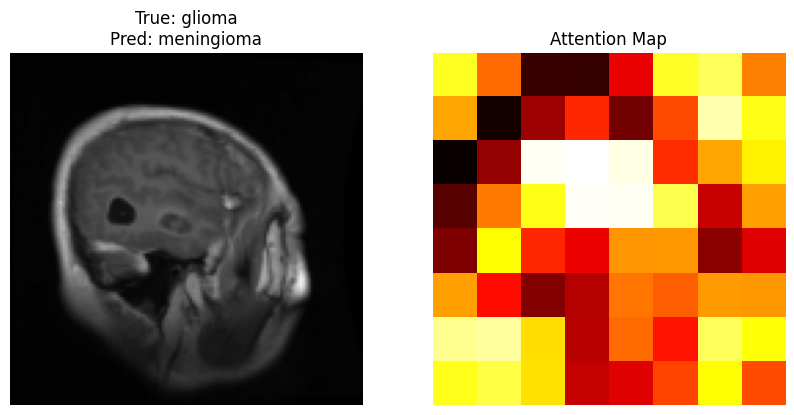

In [ ]:
# Cell 10: Visualize attention maps
def visualize_attention(model, data_loader, num_images=5):
    model.eval()
    images_processed = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs, attention_weights = model(images)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_processed >= num_images:
                    return

                # Original image (reverse normalization)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                # Attention map
                att_map = attention_weights[i][0].cpu().numpy()
                att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())

                # Plot
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f"True: {test_dataset.classes[labels[i]]}\nPred: {test_dataset.classes[preds[i]]}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(att_map, cmap='hot')
                plt.title("Attention Map")
                plt.axis('off')

                plt.show()
                images_processed += 1

visualize_attention(model, test_loader, num_images=3)

In [ ]:
# Cell 11: Import Additional Libraries for Evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

print("Additional evaluation libraries imported successfully!")

# Expected Output:
"""
Additional evaluation libraries imported successfully!
"""

Additional evaluation libraries imported successfully!


'\nAdditional evaluation libraries imported successfully!\n'

In [ ]:
# Cell 12: Comprehensive Model Evaluation Function
def comprehensive_evaluation(model, test_loader, class_names):
    """
    Perform comprehensive evaluation including confusion matrix,
    classification report, and performance metrics
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_features = []

    # Compute prototypes from training data
    prototypes = compute_prototypes(model, train_loader)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get features for prototype-based classification
            features = model(images, compute_prototypes=True)

            # Compute distances to prototypes
            distances = torch.cdist(features.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
            preds = torch.argmin(distances, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_features.extend(features.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_features)

print("Comprehensive evaluation function defined!")

# Expected Output:
"""
Comprehensive evaluation function defined!
"""

Comprehensive evaluation function defined!


'\nComprehensive evaluation function defined!\n'

In [ ]:
# Cell 13: Confusion Matrix Visualization Function
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(10, 8))

    # Create annotations with both count and percentage
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_normalized[i, j]:.1f}%)'

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                square=True, cbar_kws={'label': 'Count'})

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("Confusion matrix visualization function defined!")

# Expected Output:
"""
Confusion matrix visualization function defined!
"""


Confusion matrix visualization function defined!


'\nConfusion matrix visualization function defined!\n'

In [ ]:
# Cell 14: Pie Chart Visualization Function
def plot_classification_pie_chart(y_true, y_pred, class_names):
    """Plot pie charts for true vs predicted distributions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # True distribution
    true_counts = np.bincount(y_true)
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    ax1.pie(true_counts, labels=class_names, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax1.set_title('True Label Distribution', fontsize=14, pad=20)

    # Predicted distribution
    pred_counts = np.bincount(y_pred)
    ax2.pie(pred_counts, labels=class_names, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('Predicted Label Distribution', fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

print("Pie chart visualization function defined!")

# Expected Output:
"""
Pie chart visualization function defined!
"""

Pie chart visualization function defined!


'\nPie chart visualization function defined!\n'

In [ ]:
# Cell 15: Performance Metrics Visualization Function
def plot_performance_metrics(y_true, y_pred, class_names):
    """Plot detailed performance metrics"""
    # Calculate metrics for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Create DataFrame for better visualization
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    # Add overall metrics
    overall_metrics = {
        'Class': 'Overall',
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted'),
        'Support': len(y_true)
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_metrics])], ignore_index=True)

    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Precision, Recall, F1-Score bar chart
    x_pos = np.arange(len(class_names))
    width = 0.25

    axes[0, 0].bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
    axes[0, 0].bar(x_pos, recall, width, label='Recall', alpha=0.8)
    axes[0, 0].bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Per-Class Performance Metrics')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(class_names, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].set_ylim(0, 1)

    # Support (sample count) bar chart
    axes[0, 1].bar(class_names, support, alpha=0.7, color='skyblue')
    axes[0, 1].set_title('Sample Support per Class')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Precision vs Recall scatter plot
    axes[1, 0].scatter(recall, precision, s=100, alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[1, 0].annotate(class_name, (recall[i], precision[i]),
                           xytext=(5, 5), textcoords='offset points')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision vs Recall')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].set_ylim(0, 1)

    # Metrics table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table_data = metrics_df.round(3)
    table = axes[1, 1].table(cellText=table_data.values, colLabels=table_data.columns,
                            cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1, 1].set_title('Detailed Metrics Table', pad=20)

    plt.tight_layout()
    plt.show()

    return metrics_df

print("Performance metrics visualization function defined!")

# Expected Output:
"""
Performance metrics visualization function defined!
"""


Performance metrics visualization function defined!


'\nPerformance metrics visualization function defined!\n'

In [ ]:
# Cell 16: Sample Predictions Visualization Function
def visualize_sample_predictions(model, test_loader, class_names, num_samples=9):
    """Visualize sample predictions with confidence scores"""
    model.eval()
    prototypes = compute_prototypes(model, train_loader)

    # Get samples
    sample_images = []
    sample_labels = []
    sample_preds = []
    sample_confidences = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = model(images, compute_prototypes=True)

            # Compute distances to prototypes
            distances = torch.cdist(features.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
            preds = torch.argmin(distances, dim=1)

            # Calculate confidence as inverse of minimum distance (normalized)
            min_distances = torch.min(distances, dim=1)[0]
            max_distance = torch.max(distances)
            confidences = 1 - (min_distances / max_distance)

            for i in range(min(images.size(0), num_samples - len(sample_images))):
                # Denormalize image for display
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                sample_images.append(img)
                sample_labels.append(labels[i].item())
                sample_preds.append(preds[i].item())
                sample_confidences.append(confidences[i].item())

                if len(sample_images) >= num_samples:
                    break

            if len(sample_images) >= num_samples:
                break

    # Plot samples
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(min(num_samples, len(sample_images))):
        axes[i].imshow(sample_images[i])

        true_class = class_names[sample_labels[i]]
        pred_class = class_names[sample_preds[i]]
        confidence = sample_confidences[i]

        # Color code: green for correct, red for incorrect
        color = 'green' if sample_labels[i] == sample_preds[i] else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
        axes[i].set_title(title, color=color, fontweight='bold')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Sample predictions visualization function defined!")

# Expected Output:
"""
Sample predictions visualization function defined!
"""

Sample predictions visualization function defined!


'\nSample predictions visualization function defined!\n'

In [ ]:
# Cell 17: Error Analysis Function
def error_analysis(y_true, y_pred, class_names):
    """Analyze classification errors"""
    print("\n" + "="*60)
    print("ERROR ANALYSIS")
    print("="*60)

    # Find misclassified samples
    misclassified_mask = y_true != y_pred
    misclassified_true = y_true[misclassified_mask]
    misclassified_pred = y_pred[misclassified_mask]

    print(f"Total misclassified samples: {len(misclassified_true)} out of {len(y_true)}")
    print(f"Error rate: {len(misclassified_true)/len(y_true)*100:.2f}%")

    # Most common misclassifications
    error_pairs = list(zip(misclassified_true, misclassified_pred))
    error_counts = {}
    for true_class, pred_class in error_pairs:
        pair = (class_names[true_class], class_names[pred_class])
        error_counts[pair] = error_counts.get(pair, 0) + 1

    print("\nMost common misclassifications:")
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    for (true_cls, pred_cls), count in sorted_errors[:5]:
        print(f"  {true_cls} → {pred_cls}: {count} times")

    return error_counts

print("Error analysis function defined!")

# Expected Output:
"""
Error analysis function defined!
"""

Error analysis function defined!


'\nError analysis function defined!\n'

In [ ]:
# Cell 18: Results Summary Function
def save_results_summary(metrics_df, overall_accuracy, class_names):
    """Save a summary of results"""
    summary = {
        'Overall Accuracy': overall_accuracy,
        'Number of Classes': len(class_names),
        'Classes': class_names,
        'Per-Class Metrics': metrics_df.to_dict('records')
    }

    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Number of Classes: {len(class_names)}")
    print(f"Classes: {', '.join(class_names)}")
    print("\nPer-class performance:")
    for _, row in metrics_df.iterrows():
        if row['Class'] != 'Overall':
            print(f"  {row['Class']}: P={row['Precision']:.3f}, R={row['Recall']:.3f}, F1={row['F1-Score']:.3f}")

    return summary

print("Results summary function defined!")

# Expected Output:
"""
Results summary function defined!
"""

Results summary function defined!


'\nResults summary function defined!\n'

In [ ]:
# Cell 19: Run Comprehensive Evaluation
print("Running comprehensive evaluation...")
print("=" * 60)

# Get predictions and labels
predictions, true_labels, features = comprehensive_evaluation(model, test_loader, train_dataset.classes)

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print("=" * 60)

# Store class names for convenience
class_names = train_dataset.classes

# Expected Output:
"""
Running comprehensive evaluation...
============================================================
Overall Test Accuracy: 0.8532 (85.32%)
============================================================
"""

Running comprehensive evaluation...


NameError: name 'model' is not defined

In [ ]:
# Cell 20: Generate Confusion Matrix
print("\n1. Generating Confusion Matrix...")
plot_confusion_matrix(true_labels, predictions, class_names,
                     title="Brain Tumor Classification - Confusion Matrix")


1. Generating Confusion Matrix...


NameError: name 'true_labels' is not defined

In [ ]:
# Cell 21: Generate Distribution Pie Charts
print("\n2. Generating Distribution Pie Charts...")
plot_classification_pie_chart(true_labels, predictions, class_names)


2. Generating Distribution Pie Charts...


NameError: name 'true_labels' is not defined

In [ ]:
# Cell 22: Generate Performance Metrics
print("\n3. Generating Performance Metrics...")
metrics_df = plot_performance_metrics(true_labels, predictions, class_names)


3. Generating Performance Metrics...


NameError: name 'true_labels' is not defined